# Identificação de Cargas através de Gráfico de Recorrência

* `Artigo:` ...
* `URL`: ...
* `Source-code`: ...
* `Estratégia proposta`: converter série-temporal em GRÁFICO DE RECORRÊNCIA, extrair características com DNN (VG16) e classificação supervisionada.

# Carregando ambiente e parâmetros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('text', usetex=False)
from matplotlib.image import imsave
import pandas as pd
import pickle as cPickle
import os, sys, cv2
from math import *
from pprint import pprint
from tqdm import tqdm_notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from glob import glob
from IPython.display import display

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from pyts.image import RecurrencePlot

REDD_RESOURCES_PATH = 'datasets/REDD'
BENCHMARKING2_RESOURCES_PATH = 'benchmarkings/Imaging-NILM-time-series/'

HYPOTHESIS_RESOURCES_PATH = 'datasets/hipotese1-recurrenceplot-vggembedding/'

sys.path.append(os.path.join(BENCHMARKING2_RESOURCES_PATH, ''))

from serie2QMlib import *

# Pré-processamento dos dados 

In [2]:
def standardize(serie):
    dev = np.sqrt(np.var(serie))
    mean = np.mean(serie)
    return [(each - mean) / dev for each in serie]

# Rescale data into [0,1]
def rescale(serie):
    maxval = max(serie)
    minval = min(serie)
    gap = float(maxval - minval)
    return [(each - minval) / gap for each in serie]

#modified from https://stackoverflow.com/questions/33650371/recurrence-plot-in-python
from sklearn.metrics import pairwise
def recurrence_plot(s, eps=None, steps=None, scaling = False):
    if type(s) == list:
        s = np.array(s)[:, None]
    if scaling:
        s = rescale(s)
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    #Z = squareform(d)
    return d

## Parâmetros gerais dos dados utilizados na modelagem (treino e teste)

In [3]:
#################################
###Define the parameters here####
#################################

#datafiles = ['dish washer1-1']  # Data file name (TODO: alterar aqui)
#trains = [250]  # Number of training instances (because we assume training and test data are mixed in one file)
size = [32]  # PAA size
#GAF_type = 'GADF'  # GAF type: GASF, GADF
#save_PAA = True  # Save the GAF with or without dimension reduction by PAA: True, False
#rescale_type = 'Zero'  # Rescale the data into [0,1] or [-1,1]: Zero, Minusone

directory = os.path.join(HYPOTHESIS_RESOURCES_PATH, '') #the directory will be created if it does not already exist. Here the images will be stored
if not os.path.exists(directory):
    os.makedirs(directory)

## Gerando dados

A fim de normalizar os benchmarkings, serão utilizados os dados das séries do `bechmarking 1` para o processo de Extração de Características (conversão `serie2image` - *benchmarking 2*).

## Extração de Características

In [4]:
def serie2RP(serie, scaling = False, s = 32):
    """
    Customized function to perform Series to Image conversion.
    
    Args:
        serie    : original input data (time-serie chunk of appliance/main data - REDD - benchmarking 1)
        s        : Size of output paaimage originated from serie [ INFO: PAA = (32, 32) / noPAA = (50, 50) ]
    """
    rp = None
    rpmatrix = None

    std_data = serie
    if scaling:
        std_data = rescale(std_data)
    paalistcos = recurrence_plot(std_data)#, s, None)
    # paalistcos = rescale(paa(each[1:],s,None))
    
    # paalistcos = rescaleminus(paa(each[1:],s,None))

    ################raw###################
    datacos = np.array(std_data)
    #print(datacos)
    datasin = np.sqrt(1 - np.array(std_data) ** 2)
    #print(datasin)

    paalistcos = np.array(paalistcos)
    paalistsin = np.sqrt(1 - paalistcos ** 2)

    datacos = np.matrix(datacos)
    datasin = np.matrix(datasin)

    paalistcos = np.matrix(paalistcos)
    paalistsin = np.matrix(paalistsin)
    if GAF_type == 'GASF':
        paamatrix = paalistcos.T * paalistcos - paalistsin.T * paalistsin
        matrix = np.array(datacos.T * datacos - datasin.T * datasin)
    elif GAF_type == 'GADF':
        paamatrix = paalistsin.T * paalistcos - paalistcos.T * paalistsin
        matrix = np.array(datasin.T * datacos - datacos.T * datasin)
    else:
        sys.exit('Unknown GAF type!')
        
    #label = np.asarray(label)
    image = matrix
    paaimage = np.array(paamatrix)
    matmatrix = np.asarray(matmatrix)
    fullmatrix = np.asarray(fullmatrix)
    #
    # maximage = maxsample(image, s)
    # maxmatrix = np.asarray(np.asarray([each.flatten() for each in maximage]))
    
    if save_PAA == False:
        finalmatrix = matmatrix
    else:
        finalmatrix = fullmatrix

    # uncomment below if needed data in pickled form
    # pickledata(finalmatrix, label, train, datafilename)

    #gengramImgs(image, paaimage, label, directory)
    
    return image, paaimage, matmatrix, fullmatrix, finalmatrix

In [5]:
# Reading power dataset (benchmark 1)
df_power_chunks = pd.read_csv("benchmarkings/cs446 project-electric-load-identification-using-machine-learning/datasets/df_power_chunks.csv", index_col=[0])

print('Columns: ')
pprint(list(df_power_chunks.columns))

Columns: 
['POWER_0',
 'POWER_1',
 'POWER_2',
 'POWER_3',
 'POWER_4',
 'POWER_5',
 'POWER_6',
 'POWER_7',
 'POWER_8',
 'POWER_9',
 'POWER_10',
 'POWER_11',
 'POWER_12',
 'POWER_13',
 'POWER_14',
 'POWER_15',
 'POWER_16',
 'POWER_17',
 'POWER_18',
 'POWER_19',
 'POWER_20',
 'POWER_21',
 'POWER_22',
 'POWER_23',
 'POWER_24',
 'POWER_25',
 'POWER_26',
 'POWER_27',
 'POWER_28',
 'POWER_29',
 'APLIANCE_3',
 'APLIANCE_4',
 'APLIANCE_6',
 'APLIANCE_7',
 'APLIANCE_10',
 'APLIANCE_11',
 'APLIANCE_13',
 'APLIANCE_17',
 'APLIANCE_19']


In [6]:
attr_columns_idx = list(range(0, 30))
label_columns_idx = df_power_chunks.columns[range(30, 39)]

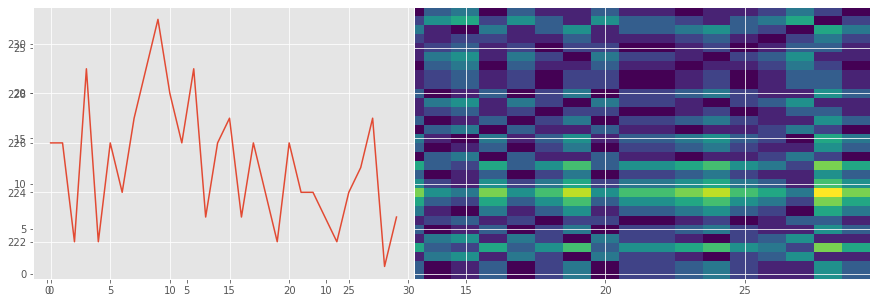

In [7]:
# Testando função de conversão serie -> RP
# serie = list(np.sin(np.linspace(0,24,1000)))
serie = df_power_chunks.iloc[22, attr_columns_idx].tolist() 
image = RecurrencePlot().fit_transform([serie])[0]

# Visualizing Serie/RP
fig = plt.figure(figsize=(15,5))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image, origin="lower", aspect="auto")
ax = fig.add_subplot(1, 2, 1)
plt.plot(list(range(0,len(serie))), serie);

In [8]:
print("Processing dataset (Series to Images)...")

image_size_px = 32
image_size_inch = round(image_size_px / 71, 2) # Convert px to inch

fig = plt.figure(frameon=False)
fig.set_size_inches(image_size_inch, image_size_inch) # 0.45inch = 32px

rp_series = []

X_rp = RecurrencePlot().fit_transform(df_power_chunks.iloc[:, attr_columns_idx].values)

for idx, row in tqdm_notebook(df_power_chunks.iterrows(), total = df_power_chunks.shape[0]):
    
    serie = row[attr_columns_idx].tolist() 
    # Binary label status
    labels = row[label_columns_idx].astype('int').astype('str').tolist()
    labels_str = ''.join(labels) # Concat labels

    image = X_rp[idx]#recurrence_plot(serie, scaling=True)
    
#     # Visualizing Serie/RP
#     fig = plt.figure(figsize=(20,15))
#     fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
#     ax = fig.add_subplot(1, 2, 1)
#     ax.imshow(image, aspect="auto")
#     ax = fig.add_subplot(2, 2, 1)
#     plt.plot(list(range(0,len(serie))), serie)

    # Persist image data files (PAA - noPAA)
    np.save(
        os.path.join( 
            HYPOTHESIS_RESOURCES_PATH, 
            "{}_{}.npy".format(idx, labels_str) 
        ), 
        image
    )
    # x is the array you want to save 
    imsave(
        os.path.join( 
            HYPOTHESIS_RESOURCES_PATH, 
            "{}_{}_color.png".format(idx, labels_str) 
        ), 
        arr=image
    )
#     ax = plt.Axes(fig, [0., 0., 1., 1.])
#     ax.set_axis_off()
#     fig.add_axes(ax)
#     ax.imshow(image, aspect='auto')
#     fig.savefig(os.path.join( HYPOTHESIS_RESOURCES_PATH, "{}_{}_color.png".format(idx, labels_str) ))
    Image.fromarray(image*255).convert('RGB').resize((image_size_px, image_size_px)).save(os.path.join( HYPOTHESIS_RESOURCES_PATH, "{}_{}_black.png".format(idx, labels_str) ))
    rp_series.append( list([idx]) + list(image.flatten()) + list(labels) )
    
    #break
#print('!')

Processing dataset (Series to Images)...


<Figure size 32.4x32.4 with 0 Axes>

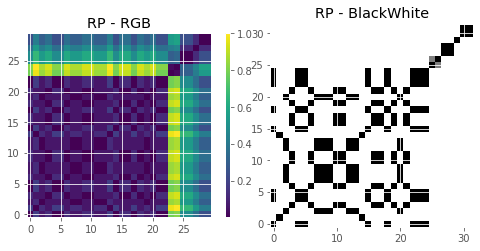

In [9]:
# VIsualizgin some results...
plt.figure(figsize=(8,6));

ax1 = plt.subplot(121);
plt.title("RP - RGB");
color_rp = plt.imread(os.path.join( HYPOTHESIS_RESOURCES_PATH, "{}_{}_color.png".format(idx, labels_str) ))
plt.imshow(color_rp, origin="lower");

divider = make_axes_locatable(ax1);
cax = divider.append_axes("right", size="2.5%", pad=0.2);
plt.colorbar(cax=cax);

ax2 = plt.subplot(122);
black_rp = plt.imread(os.path.join( HYPOTHESIS_RESOURCES_PATH, "{}_{}_black.png".format(idx, labels_str) ))
plt.title("RP - BlackWhite");
plt.imshow(black_rp, origin="lower");

## Persistência

In [10]:
print('Saving processed data...')
df_plots = pd.DataFrame(
    data = rp_series,
    columns = list(["IDX"]) + ["DIMESION_{}".format(d) for d in range(len(image.flatten()))] + list(label_columns_idx)
)
df_plots.to_csv(os.path.join( HYPOTHESIS_RESOURCES_PATH, "df_plots.csv"))


Saving processed data...


# Modelagem

In [11]:
def metrics(test, predicted):
    ##CLASSIFICATION METRICS

    acc = accuracy_score(test, predicted)
    prec = precision_score(test, predicted)
    rec = recall_score(test, predicted)    
    f1 = f1_score(test, predicted)
    f1m = f1_score(test, predicted, average='macro')
    

    # print('f1:',f1)
    # print('acc: ',acc)
    # print('recall: ',rec)
    # print('precision: ',prec)

    # # to copy paste print
    #print("{:.4}\t{:.4}\t{:.4}\t{:.4}\t{:.4}".format(acc, prec, rec, f1, f1m))

    # ##REGRESSION METRICS
    # mae = mean_absolute_error(test_Y,pred)
    # print('mae: ',mae)
    # E_pred = sum(pred)
    # E_ground = sum(test_Y)
    # rete = abs(E_pred-E_ground)/float(max(E_ground,E_pred))
    # print('relative error total energy: ',rete)
    return acc, prec, rec, f1, f1m


def plot_predicted_and_ground_truth(test, predicted):
    #import matplotlib.pyplot as plt
    plt.plot(predicted.flatten(), label = 'pred')
    plt.plot(test.flatten(), label= 'Y')
    plt.show()
    return

## Benchmarking (replicando estudo)

In [12]:
# Building dnn model (feature extraction)
vgg16_model = VGG16(
    include_top=False, 
    weights='imagenet', 
    input_tensor=None, 
    input_shape=(100, 100, 3), 
    pooling='avg',
    classes=1000
)

In [13]:
# Loading data files (images and labels arrays)

# Colored recurrence plots generated
images = []
images = sorted(glob( 
    os.path.join(
        HYPOTHESIS_RESOURCES_PATH, 
        "*_color.png"
    ) 
))

In [14]:
# model.compile()

# Feature extraction process with VGG16
vgg16_feature_list = [] # Attributes array (vgg16 embedding)
labels = [] # Extract labels from name of image path[]

for path in tqdm_notebook(images):
    
    img = keras_image.load_img(path, target_size=(100, 100))
    x = keras_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # "Extracting" features...
    vgg16_feature = vgg16_model.predict(x)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())
    
    # Image (chuncked serie) 
    file_name = path.split("\\")[-1].split(".")[0]
    image_labels = [int(l) for l in list(file_name.split("_")[1])]
    labels.append(image_labels)

feature_array = np.array(vgg16_feature_list)

In [15]:
# Spliting Train/Test data
X_train, X_test, y_train, y_test = train_test_split(
    feature_array, 
    labels, 
    test_size=0.30,
    random_state=42
)

# ##### Uncomment classifier of choice #####

# clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=500, learning_rate=0.25)

# clf = AdaBoostClassifier(n_estimators=1000, learning_rate=0.25)

# clf = AdaBoostClassifier(RandomForestClassifier(random_state=0.7), n_estimators=1000, learning_rate=0.5)

# Training supervised classifier
clf = DecisionTreeClassifier(max_depth=15)

# clf = RandomForestClassifier(n_estimators=1000, random_state=7)

# clf = MLPClassifier(hidden_layer_sizes=500, batch_size=20)

# Train classifier
clf.fit(X_train, y_train)

# Save classifier for future use
#joblib.dump(clf, 'Tree'+'-'+device+'-redd-all.joblib')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


RESULT ANALYSIS


ON/OFF State Charts
-------------------------------------------------------------------------------------------------------------------


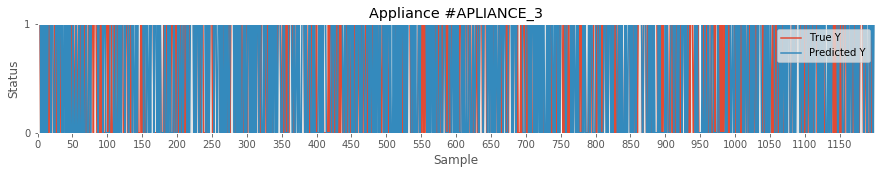

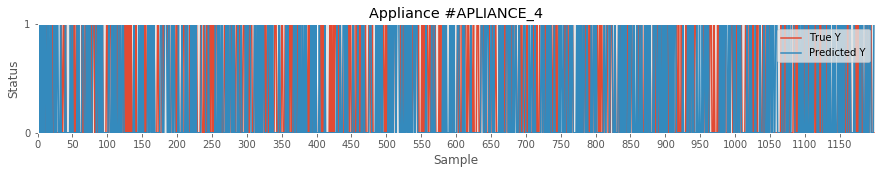

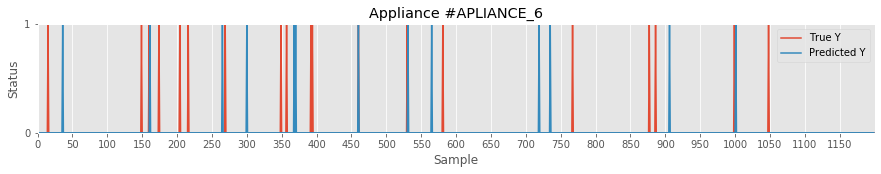

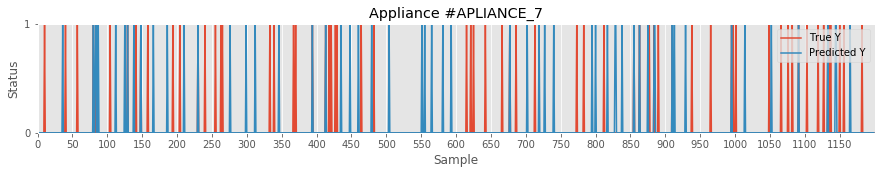

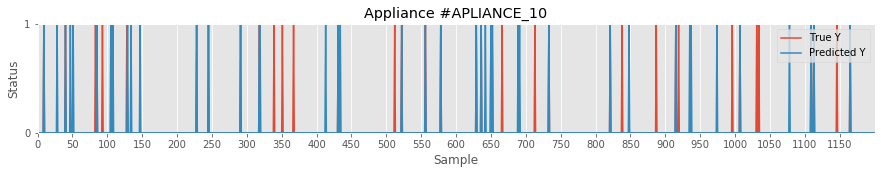

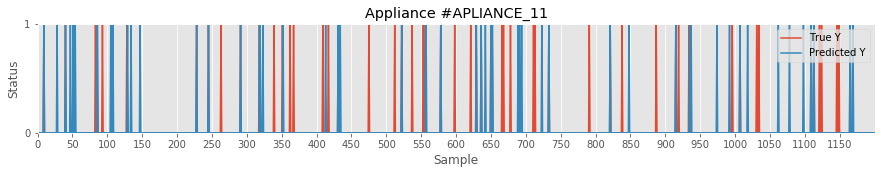

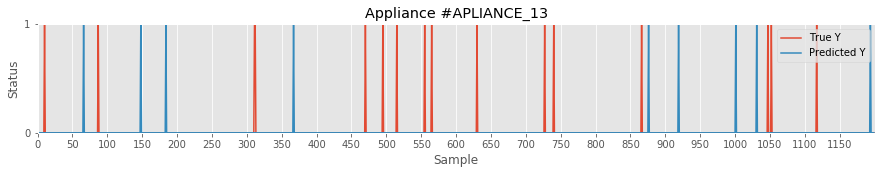

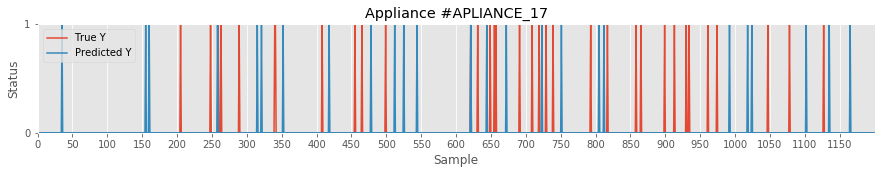

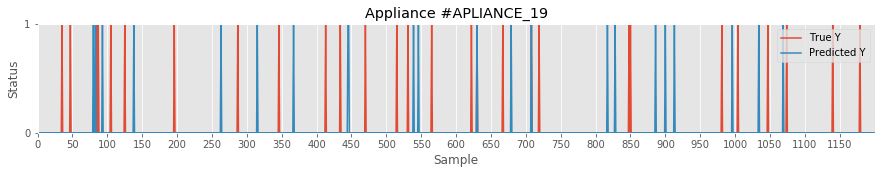

-------------------------------------------------------------------------------------------------------------------

FINAL PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro
0,APLIANCE_3,58.67,64.14,62.83,63.48,57.94
1,APLIANCE_4,61.67,55.23,45.13,49.67,59.36
2,APLIANCE_6,97.50,7.69,5.26,6.25,52.49
3,APLIANCE_7,92.33,26.32,23.08,24.59,60.28
4,APLIANCE_10,97.08,53.66,57.89,55.70,77.09
5,APLIANCE_11,94.67,41.51,40.00,40.74,68.97
6,APLIANCE_13,97.92,0.00,0.00,0.00,49.47
7,APLIANCE_17,95.25,4.00,2.94,3.39,50.48
8,APLIANCE_19,96.17,9.09,7.14,8.00,53.02



OVERALL AVERAGE PERFORMANCE:


,Metric,Result (%)
0,Accuracy,87.92
1,Precision,29.07
2,Recall,27.14
3,F1-score,27.98
4,F1-macro,58.79


In [16]:
# Predict test data
y_pred = clf.predict(X_test)

# Print metrics
final_performance = []
y_test = np.array(y_test)
y_pred = np.array(y_pred)

print("")
print("RESULT ANALYSIS\n\n")
print("ON/OFF State Charts")
print("-" * 115)
for i in range(y_test.shape[1]):
    
    fig  = plt.figure(figsize=(15, 2))
    plt.title("Appliance #{}".format( label_columns_idx[i]))
    plt.plot(y_test[:, i].flatten(), label = "True Y")
    plt.plot( y_pred[:, i].flatten(), label = "Predicted Y")
    plt.xlabel('Sample')
    plt.xticks(range(0, y_test.shape[0], 50))
    plt.xlim(0, y_test.shape[0])
    plt.ylabel('Status')
    plt.yticks([0, 1])
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
    acc, prec, rec, f1, f1m = metrics(y_test[:, i], y_pred[:, i])
    final_performance.append([
        label_columns_idx[i], 
        round(acc*100, 2), 
        round(prec*100, 2), 
        round(rec*100, 2), 
        round(f1*100, 2), 
        round(f1m*100, 2)
    ])

print("-" * 115)
print("")
print("FINAL PERFORMANCE BY APPLIANCE (LABEL):")
df_metrics = pd.DataFrame(
    data = final_performance,
    columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro"]
)
display(df_metrics)

print("")
print("OVERALL AVERAGE PERFORMANCE:")
final_performance = np.mean(np.array(final_performance)[:, 1:].astype(float), axis = 0)
display(pd.DataFrame(
    data = {
        "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "F1-macro"],
        "Result (%)": [round(p, 2) for p in final_performance]
    }
))
# print("-----------------")
# print("Accuracy  : {0:.2f}%".format( final_performance[0] ))
# print("Precision : {0:.2f}%".format( final_performance[1] ))
# print("Recall    : {0:.2f}%".format( final_performance[2] ))
# print("F1-score  : {0:.2f}%".format( final_performance[3] ))
# print("F1-macro  : {0:.2f}%".format( final_performance[4] ))
# print("-----------------")

# Conclusões

A adoção do gráfico de recorrência para o processo de classificação de série temporal, no contexto de NILM, apresentou desempenho superior ao método GAF (benchmarking 2).

Agora, o próximo passo é estruturar um pipeline único de comparação das 3 abordagens, que inclui desde o pré-processamento até a análise de resultados.